In [1]:
# Show the figures / plots inside the notebook
import numpy as np
import cv2
import matplotlib.pyplot as plt



Utility functions

In [2]:
def show_hist(image, title, ignore_first=1):
    # Calculate the histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    # Ignore the first 'ignore_first' values in the histogram
    hist[0:ignore_first] = 0

    # Plot the modified histogram
    plt.plot(hist, color='black')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

#this function takes an images and divide into 4 parts and calculate the histogram of each part
def local_hist(image):
    part1 = image[0:image.shape[0]//2, 0:image.shape[1]//2]
    part2 = image[0:image.shape[0]//2, image.shape[1]//2:image.shape[1]]
    part3 = image[image.shape[0]//2:image.shape[0], 0:image.shape[1]//2]
    part4 = image[image.shape[0]//2:image.shape[0], image.shape[1]//2:image.shape[1]]

    show_hist(part1, 'Histogram of part1')
    show_hist(part2, 'Histogram of part2')
    show_hist(part3, 'Histogram of part3')
    show_hist(part4, 'Histogram of part4')

#this function takes array of threshold values and an image and return the image after applying the threshold to each part
def local_thresholding(thresholds, image):
    # Create a copy of the image
    image_thresholded = np.copy(image)

    # Divide the image into 4 parts
    part1 = image_thresholded[0:image.shape[0]//2, 0:image.shape[1]//2]
    part2 = image_thresholded[0:image.shape[0]//2, image.shape[1]//2:image.shape[1]]
    part3 = image_thresholded[image.shape[0]//2:image.shape[0], 0:image.shape[1]//2]
    part4 = image_thresholded[image.shape[0]//2:image.shape[0], image.shape[1]//2:image.shape[1]]

    # Apply thresholding
    image_thresholded[0:image.shape[0]//2, 0:image.shape[1]//2] = np.where(part1 < thresholds[0], 0, 255)
    image_thresholded[0:image.shape[0]//2, image.shape[1]//2:image.shape[1]] = np.where(part2 < thresholds[1], 0, 255)
    image_thresholded[image.shape[0]//2:image.shape[0], 0:image.shape[1]//2] = np.where(part3 < thresholds[2], 0, 255)
    image_thresholded[image.shape[0]//2:image.shape[0], image.shape[1]//2:image.shape[1]] = np.where(part4 < thresholds[3], 0, 255)
    

    return image_thresholded
    

Reading the image and applying face detection using haar cascades

In [62]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# mouth_cascade = cv2.CascadeClassifier('./haar/haarcascade_smile.xml')

# if mouth_cascade.empty():
#   raise IOError('Unable to load the mouth cascade classifier xml file')

# Read the input image
image_path = './images/amin2.png'
img = cv2.imread(image_path)

#resize image 716x900
img = cv2.resize(img, (716, 1000))


# Perform face detection
faces = face_cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=5)

# Draw rectangles around the detected faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Display the result
cv2.imshow('Face Detection', img)
cv2.waitKey(0)
cv2.destroyAllWindows()




Remove background using Grabcut algorithm


In [63]:
#This line creates an empty binary mask with the same dimensions as the input image 
#The mask is initially filled with zeros, indicating that no pixels are currently classified as either foreground or background.
mask = np.zeros(img.shape[:2], np.uint8)
cv2.grabCut(img, mask, faces[0], None, None, 5, cv2.GC_INIT_WITH_RECT)

#if mask is 2 or 0, it is converted to 0, otherwise converted to 1
#2 or 0 means background, 1 or 3 means foreground
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

#converting the input image to grayscale and applying the mask
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img * mask2

cv2.imshow("Foreground", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Segmenting the mouth area from the face and applying gamma correction

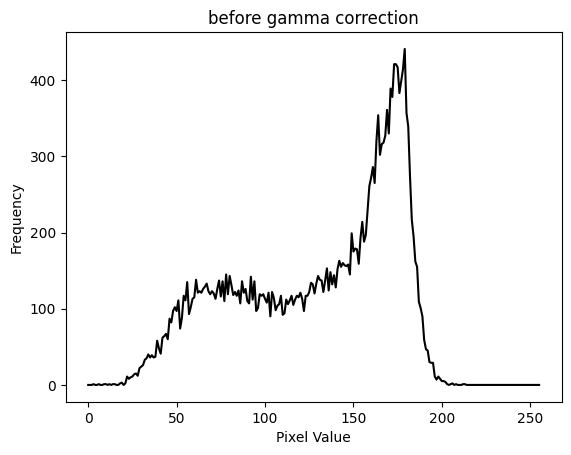

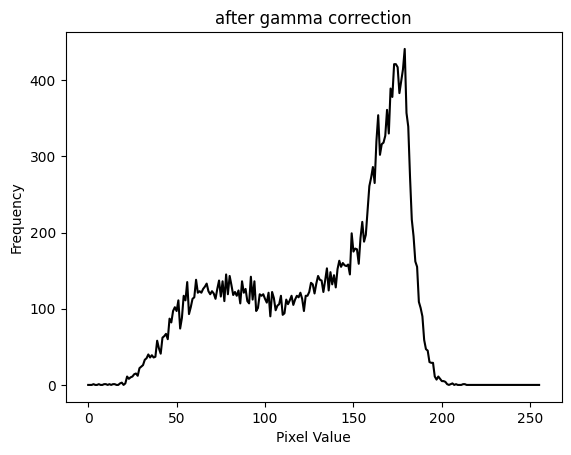

In [64]:
#segment the face
img_temp = img.copy()
roi_gray_mouth_region = []
for (x, y, w, h) in faces:
    #take the region of interest which is the face
    roi_gray = img_temp[y:y+h, x:x+w]
    
    #then take the mouth region only
    roi_gray_mouth_region = roi_gray[int(roi_gray.shape[0]/1.5):roi_gray.shape[0], int(roi_gray.shape[1]/4):int(roi_gray.shape[1]/4)+int(roi_gray.shape[1]/2)]

    cv2.imshow('mouth Segmentation before gamma correction', roi_gray_mouth_region)

    #plot histogram
    show_hist(roi_gray_mouth_region, "before gamma correction")
    
    #apply gamma correction
    gamma = 1
    roi_gray_mouth_region = np.array(255 * (roi_gray_mouth_region / 255) ** gamma, dtype = 'uint8')

    #plot histogram
    show_hist(roi_gray_mouth_region, "after gamma correction")
    
    cv2.imshow('mouth Segmentation after gamma correction', roi_gray_mouth_region)
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()

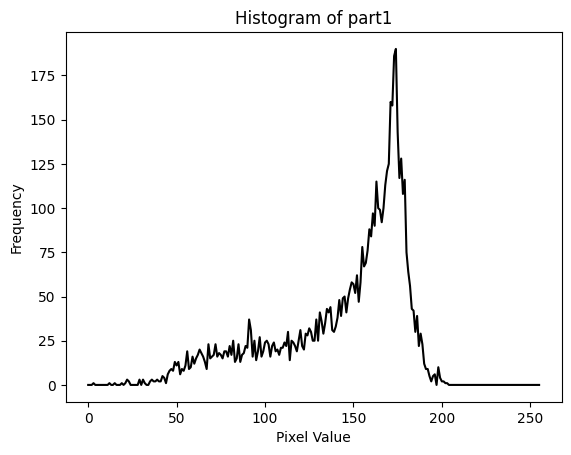

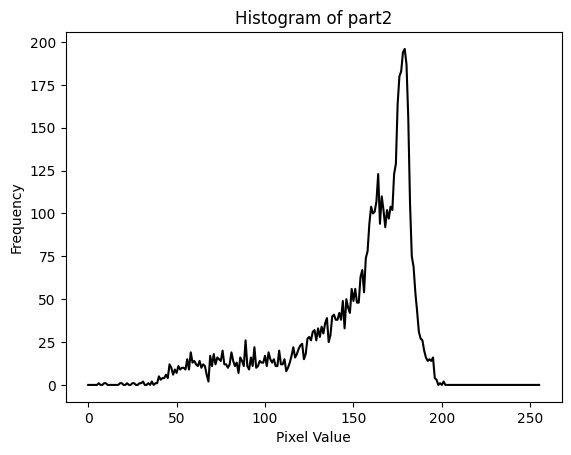

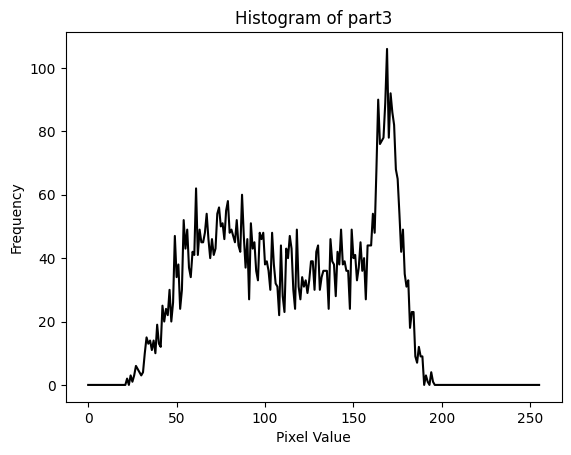

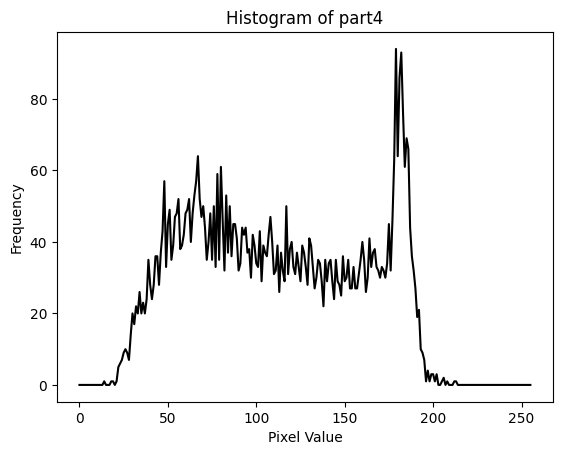

In [65]:
local_hist(roi_gray_mouth_region)


Applying segmentation using threshholding

In [48]:
max_value = np.max(roi_gray_mouth_region)
mean_value = np.mean(roi_gray_mouth_region)
# roi_gray_mouth_region[roi_gray_mouth_region < 210] = 0
# roi_gray_mouth_region[(roi_gray_mouth_region < 50) | (roi_gray_mouth_region >= 70)] = 0
# roi_gray_mouth_region[(roi_gray_mouth_region >= 50) & (roi_gray_mouth_region < 70)] = 255

roi_gray_mouth_region = local_thresholding([150, 130, 150, 150], roi_gray_mouth_region)


# roi_gray_mouth_region = np.where((roi_gray_mouth_region < 180) & (roi_gray_mouth_region > 110), 255, 0).astype('uint8')

cv2.imshow('After Threshholding', roi_gray_mouth_region)
cv2.waitKey(0)
cv2.destroyAllWindows()

Applying opening to remove noise

In [47]:
kernel = np.ones((5, 5), np.uint8)

# Apply opening operation to the binary mask
opened_mask = cv2.morphologyEx(roi_gray_mouth_region, cv2.MORPH_OPEN, kernel)

roi_gray_mouth_region = roi_gray_mouth_region * opened_mask

cv2.imshow("Opened Mask", roi_gray_mouth_region*255)  # Multiply by 255 for better visualization
cv2.waitKey(0)
cv2.destroyAllWindows()